Topics to be covered:

1. Text Generation\
    1.1 Using GPT to generate text\
    1.2 Calculating the text generation loss
2. Text Evaluation
3. Training & Validation Losses
4. Training the LLM
...

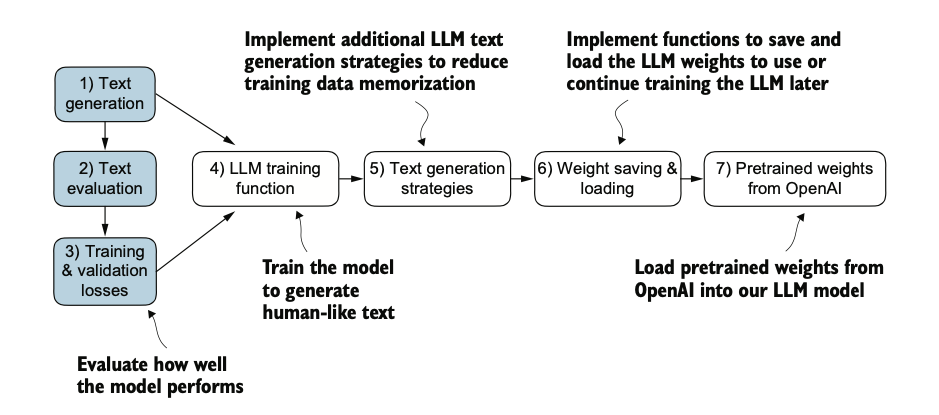

# 1. Text Generation

## 1.1 Using GPT to generate text

In [5]:
import torch
from chapter4 import GPTModel

In [6]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256, # was previously 1024
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (token_embed): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Li

#### Using the GPTModel instance, we adopt the generate_text function from chapter 4 and introduce two handy functions: text_to_token_ids and token_ids_to_text. These functions facilitate the conversion between text and token representations, a technique we will utilize throughout this chapter.

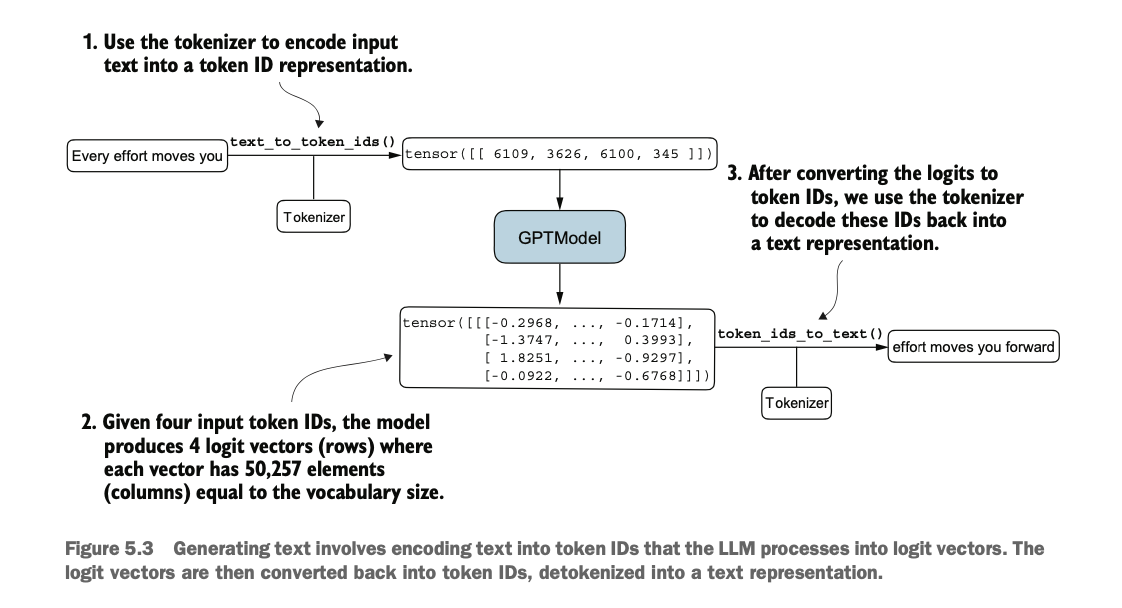

In [7]:
import tiktoken

# generate_text from chapter 4
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Get the idx of the vocab entry with the highest logits value
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [8]:
# utility functions for text to token ID and vice versa conversions
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # adding batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flatten = token_ids.squeeze(0) # removing batch dimension
    return tokenizer.decode(flatten.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding('gpt2')

# starting text gets fed to text_to_token_ids for encoding, and that gets fed to generate_text_simple to
# generate the remaining tokens
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

decoded_and_generated = token_ids_to_text(token_ids, tokenizer)

print(f"Token IDs for the inputted text (i.e. 'start_context'):\n{text_to_token_ids(start_context, tokenizer)}\n\nGenerated token IDs based on the inputted text and context length:\n{token_ids}\n\nOutput text via decoding the generated token IDs:\n{decoded_and_generated}")

Token IDs for the inputted text (i.e. 'start_context'):
tensor([[6109, 3626, 6100,  345]])

Generated token IDs based on the inputted text and context length:
tensor([[ 6109,  3626,  6100,   345, 34245,  5139,  2492, 25405, 17434, 17853,
          5308,  3398, 13174, 43071]])

Output text via decoding the generated token IDs:
Every effort moves you rentingetic wasnم refres RexMeCHicular stren


## 1.2 Calculating the text generation loss

Le's consider the following two examples. 

In [9]:
inputs = torch.tensor([[16833, 3626, 6100], # "every effort moves"
                        [40, 1107, 588]]) # "I really like"

matching these inputs, creating targets we want the model to produce (these are inputs that are basically shifted by one position to the right).

In [10]:
targets = torch.tensor([[3626, 6100, 345 ], # " effort moves you"
                        [1107, 588, 11311]]) # " really like chocolate"

targets are basically $ y $ values that we want the model to produce. In other words, we will compare what the model generates (aka ŷ) with the $ y $ values.

Symbolically (in a very loose sense):

$$ loss = y - ŷ $$

where $ y $ is the target and ŷ is the model's output.

In [11]:
# calculating our ŷ

with torch.no_grad(): # diasbling gradient tracking as this isn't yet the training stage
    logits = model(inputs)
probabilities = torch.softmax(logits, dim=-1)
print(f"Probabilities:\n{probabilities}\n\nProbabilities' shape: {probabilities.shape}")

Probabilities:
tensor([[[1.8849e-05, 1.5172e-05, 1.1687e-05,  ..., 2.2409e-05,
          6.9776e-06, 1.8776e-05],
         [9.1569e-06, 1.0062e-05, 7.8786e-06,  ..., 2.9090e-05,
          6.0103e-06, 1.3571e-05],
         [2.9877e-05, 8.8507e-06, 1.5741e-05,  ..., 3.5456e-05,
          1.4094e-05, 1.3526e-05]],

        [[1.2561e-05, 2.0538e-05, 1.4332e-05,  ..., 1.0389e-05,
          3.4784e-05, 1.4239e-05],
         [7.2731e-06, 1.7864e-05, 1.0565e-05,  ..., 2.1206e-05,
          1.1390e-05, 1.5559e-05],
         [2.9496e-05, 3.3605e-05, 4.1029e-05,  ..., 6.5249e-06,
          5.8203e-05, 1.3698e-05]]])

Probabilities' shape: torch.Size([2, 3, 50257])


In [12]:
token_ids = torch.argmax(probabilities, dim=-1, keepdim=True)
token_ids

tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])

In [13]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}") # for the 1st batch
print(f"Outputs batch 1:"
f" {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


It can be seen that the model, at this stage, produces random gibberish. This is because the model has not been trained yet.

Now, as the text generation part is done, it's time to move on to the text evaluation part.

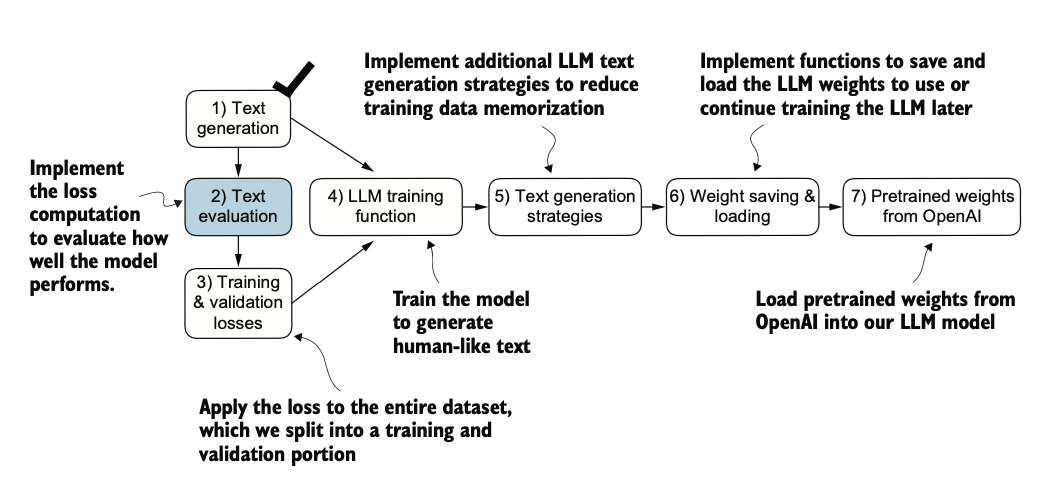

---

# 2. Text Evaluation

For each of the two input texts, printing the initial softmax probability scores corresponding to the target tokens:

In [14]:
probabilities = torch.softmax(logits, dim=-1)
print(probabilities, probabilities.shape)
print("All probabilities ↑\n")

text_idx = 0
target_probas_1 = probabilities[text_idx, [0, 1, 2], [3626, 6100, 345]]
print("\nText 1:", target_probas_1)

tensor([[[1.8849e-05, 1.5172e-05, 1.1687e-05,  ..., 2.2409e-05,
          6.9776e-06, 1.8776e-05],
         [9.1569e-06, 1.0062e-05, 7.8786e-06,  ..., 2.9090e-05,
          6.0103e-06, 1.3571e-05],
         [2.9877e-05, 8.8507e-06, 1.5741e-05,  ..., 3.5456e-05,
          1.4094e-05, 1.3526e-05]],

        [[1.2561e-05, 2.0538e-05, 1.4332e-05,  ..., 1.0389e-05,
          3.4784e-05, 1.4239e-05],
         [7.2731e-06, 1.7864e-05, 1.0565e-05,  ..., 2.1206e-05,
          1.1390e-05, 1.5559e-05],
         [2.9496e-05, 3.3605e-05, 4.1029e-05,  ..., 6.5249e-06,
          5.8203e-05, 1.3698e-05]]]) torch.Size([2, 3, 50257])
All probabilities ↑


Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])


In [15]:
text_idx = 1
target_probas_2 = probabilities[text_idx, [0, 1, 2], [1107, 588, 11311]]
print("Text 2:", target_probas_2)

Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [16]:
# Therefore, the three target token ID probabilities for each batch are:
print(f"Text 1: {target_probas_1}\nText 2: {target_probas_2}")

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


Now calculating the loss for the probability scores of these two example batches.

Firstly, calculating the negative average log probability of the target tokens:

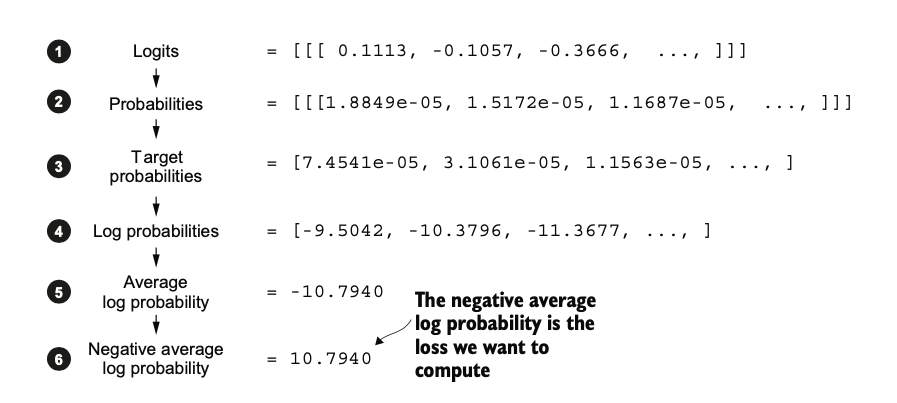

In [17]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [18]:
neg_avg_log_probas = -torch.mean(log_probas)
neg_avg_log_probas

tensor(10.7940)

#### NOTE

In deep learning, the term for turning this negative value, –10.7940, into 10.7940, is known as the cross entropy loss. Instead of doing these step-by-step calculations, we can use the `cross_entropy` function like this:

``` python
import torch.nn.functional as F
loss = F.cross_entropy(input, target)
```

Let's apply this to the two examples:

In [19]:
inputs = torch.tensor([[16833, 3626, 6100], # "every effort moves"
                        [40, 1107, 588]]) # "I really like"

targets = torch.tensor([[3626, 6100, 345 ], # " effort moves you"
                        [1107, 588, 11311]]) # " really like chocolate"

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

with torch.no_grad(): # diasbling gradient tracking as this isn't yet the training stage
    logits = model(inputs)
# probabilities = torch.softmax(logits, dim=-1)

In [20]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [21]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print(f"Flattened logits: {logits_flat.shape}\nFlattened targets: {targets_flat.shape}")

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [22]:
import torch.nn.functional as F

loss = F.cross_entropy(logits_flat, targets_flat)
print("Loss:", loss)

perplexity = torch.exp(loss)
print("Perplexity:", perplexity)

Loss: tensor(10.7940)
Perplexity: tensor(48725.8203)


#### ↑ What is happening here?
Perplexity is often considered more interpretable than the raw loss value because it signifies the effective vocabulary size about which the model is uncertain at each step. In the given example, this would translate to **the model being unsure about which among 48,725 tokens in the vocabulary to generate as the next token**.

---

## 3. Calculating the Training & Validation Set Losses

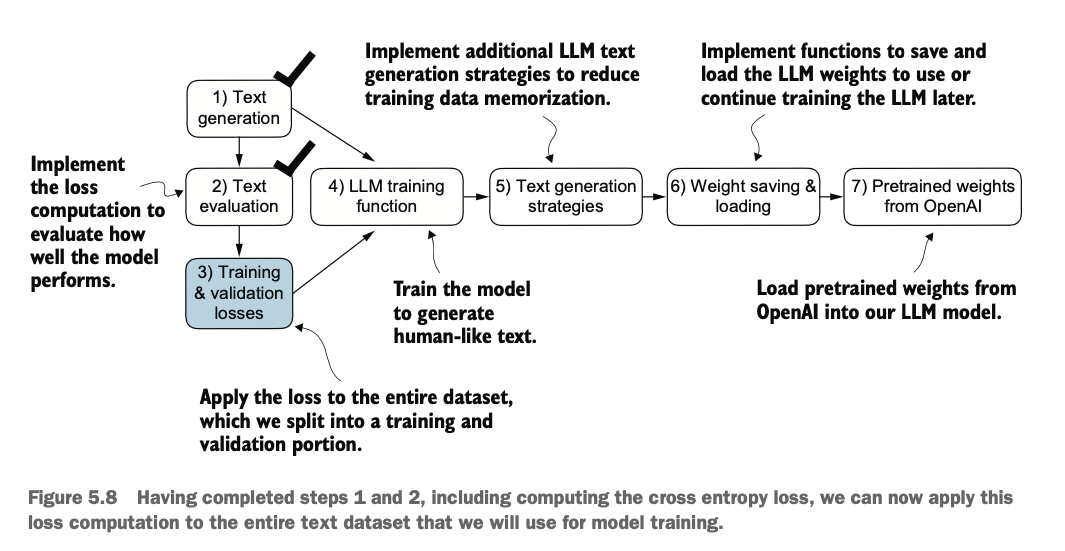

#### To compute the loss on the training and validation datasets, I'm gonna use the "The Verdict" short story.

In [23]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [25]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print(f"Total characters: {total_characters}\nTotal tokens in the dataset: {total_tokens}")

Total characters: 20479
Total tokens in the dataset: 5145


#### Next, dividing the dataset into training and validation sets, plus using the data loaders from chap 2 to prepare the batches for LLM training.

using max_length = 6 here, but for the actual data loaders, we set max_length = 256-token context length so that the model sees longer texts during training.

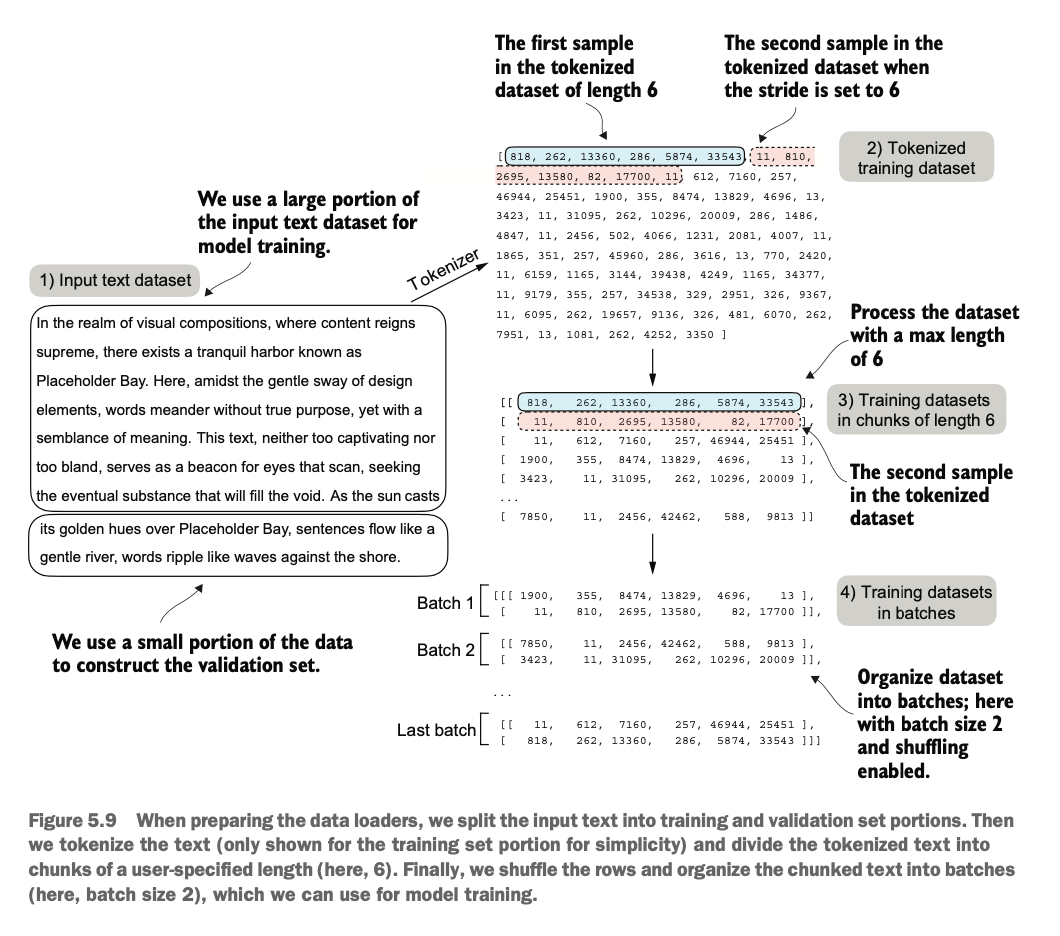

#### Now implementing data splitting and loading with a 90-10 split (90% training and 10% validation):

In [31]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

print(len(train_data), len(val_data))
print((len(train_data) + len(val_data)) - len(text_data))

18431 2048
0


In [32]:
from chapter2 import create_dataloader_v1
torch.manual_seed(123)

In [38]:
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    shuffle=True,
    drop_last=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    shuffle=True,
    drop_last=True,
    num_workers=0    
)

In [42]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("----------------------------------\n\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
----------------------------------

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


#### ↑ What is happening here?

I can see nine training set batches with two samples and 256 tokens each. Since we allocated only 10% of the data for validation, there is only one validation batch consisting of two input examples. As expected, the input data (x) and target data (y) have the same shape (the batch size times the number of tokens in each batch) since the targets are the inputs shifted by one position.

#### Implementing a utility function to calculate the cross-entropy loss of a given batch returned via the training and validation data loaders:

In [51]:
import torch.nn.functional as F

# this computes the loss for a single batch
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = F.cross_entropy(
        logits.flatten(0, 1),
        target_batch.flatten()
    )
    return loss

# this calculates the loss across all the batches in a given data loader
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0 # starting point
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader) # iterates over all batches if no fixed num_batches specified
    else:
        # if num_batches > len(data_loader), reduce the num_batches to match len(data_loader) so that it still works
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches # averaging the loss over all the batches

In [52]:
# seeing all this in action

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.987583584255642
Validation loss: 10.98110580444336


Relatively high loss. But this is to be expected since the model has not been trained yet.

---

# 4. Training the LLM